Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow import keras
from keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split, StratifiedKFold

Read data (pre-processed and with engineered features)

In [2]:
data = pd.read_csv('final_dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298513 entries, 0 to 298512
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               298513 non-null  int64  
 1   id                       298513 non-null  int64  
 2   qid1                     298513 non-null  int64  
 3   qid2                     298513 non-null  int64  
 4   question1                298513 non-null  object 
 5   question2                298513 non-null  object 
 6   is_duplicate             298513 non-null  int64  
 7   clean_q1                 298513 non-null  object 
 8   clean_q2                 298513 non-null  object 
 9   total_words_q1           298513 non-null  int64  
 10  total_words_q2           298513 non-null  int64  
 11  num_common_words         298513 non-null  int64  
 12  common_words_percentage  298513 non-null  float64
 13  fuzz_ratio               298513 non-null  int64  
 14  fuzz

Word embeddings

In [3]:
# Load pre-trained GloVe embeddings
embedding_file = "glove.6B.100d.txt"
embedding_dim = 100
word2vec = {}
with open(embedding_file, 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        word2vec[word] = vector

In [4]:
vocab_size = 20000
max_seq_length = 20

data['clean_q1'] = data['clean_q1'].apply(lambda x: str(x))
data['clean_q2'] = data['clean_q2'].apply(lambda x: str(x))
all_questions = data['clean_q1'].tolist() + data['clean_q2'].tolist()

# Create a tokenizer and fit on the questions
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(all_questions)

# Convert questions to sequences
question1_sequences = tokenizer.texts_to_sequences(data['clean_q1'])
question2_sequences = tokenizer.texts_to_sequences(data['clean_q2'])

# Pad sequences
question1 = pad_sequences(question1_sequences, maxlen=max_seq_length)
question2 = pad_sequences(question2_sequences, maxlen=max_seq_length)

# Create embedding matrix
num_words = min(vocab_size, len(tokenizer.word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Train-test split

In [5]:
features = data.iloc[:,9:].to_numpy()
y = data['is_duplicate'].to_numpy()

train_q1, test_q1, train_q2, test_q2, features_train, features_test, y_train, y_test = train_test_split(
    question1, question2, features, y, test_size=0.3, random_state=4)

In [6]:
print(train_q1.shape)
print(test_q1.shape)
print(train_q2.shape)
print(test_q2.shape)
print(features_train.shape)
print(features_test.shape)
print(y_train.shape)
print(y_test.shape)

(208959, 20)
(89554, 20)
(208959, 20)
(89554, 20)
(208959, 12)
(89554, 12)
(208959,)
(89554,)


Hyperparameter tuning

In [7]:
HP_LSTM_UNITS = hp.HParam('num_lstm_units', hp.Discrete([16, 32]))
HP_DENSE_UNITS = hp.HParam('num_dense_units', hp.Discrete([25, 50]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.2]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_LSTM_UNITS, HP_DENSE_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
)

In [16]:
def model_cv(hparams):
    no_features = 12
    lstm_units = hparams[HP_LSTM_UNITS]
    dense_units = hparams[HP_DENSE_UNITS]

    # Define input shape for questions
    question1_input = Input(shape=(max_seq_length,))
    question2_input = Input(shape=(max_seq_length,))
    features_input = Input(shape=(no_features,))

    # Define embedding layer
    embedding_layer = Embedding(num_words,
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_seq_length,
                                trainable=False)

    # Define LSTM layer with layer normalisation
    lstm_layer = LSTM(units=lstm_units)

    # Define Dropout layer
    dropout_layer = Dropout(hparams[HP_DROPOUT])

    # Define Dense layer for engineered features and determining similarity with layer normalisation
    dense_layer_1 = Dense(dense_units, activation='relu')
    dense_layer_2 = Dense(dense_units, activation='relu')

    # Define Dense output layer
    output_layer = Dense(1, activation='sigmoid')

    # Pass the input through the embedding, LSTM and dropout layer
    encoded_question1 = dropout_layer(lstm_layer(embedding_layer(question1_input)))
    encoded_question2 = dropout_layer(lstm_layer(embedding_layer(question2_input)))

    # Pass feature engineering input through dense and dropout layers
    engineered_features = dense_layer_1(features_input)

    # Concatenate outputs and pass through dense and dropout layers
    concatenated_layer = Concatenate()([encoded_question1, encoded_question2, engineered_features])
    concatenated_layer = dropout_layer(concatenated_layer)

    # Pass through final dense layer and output layer
    determine_similarity_layer = dropout_layer(dense_layer_2(concatenated_layer))
    output = output_layer(determine_similarity_layer)

    # Pack it all up into a model
    siamese_lstm = Model([question1_input, question2_input, features_input], output)

    # Compile the model with Binary Cross Entropy loss and Adam optimizer
    siamese_lstm.compile(loss='binary_crossentropy', optimizer=hparams[HP_OPTIMIZER], metrics=['accuracy'])

    initial_weights = siamese_lstm.get_weights()

    # Conduct 5-fold cross validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)
    accuracy_arr = []
    for i, (train_index, test_index) in enumerate(kf.split(np.zeros(y_train.shape[0]),y_train)):
        q1_train = train_q1[train_index,:]
        q1_val = train_q1[test_index,:]
        q2_train = train_q2[train_index,:]
        q2_val = train_q2[test_index,:]
        f_train = features_train[train_index,:]
        f_val = features_train[test_index,:]
        cv_y_train = y_train[train_index]
        cv_y_val = y_train[test_index]

        # Reset weights of model for each fold to have independent validation results across folds
        siamese_lstm.set_weights(initial_weights)
        
        print(f"Fold {i+1}:")
        siamese_lstm.fit([q1_train, q2_train, f_train], cv_y_train, batch_size=1024, epochs=1, verbose=1)
        _, accuracy = siamese_lstm.evaluate([q1_val, q2_val, f_val],cv_y_val, batch_size=1024, verbose=1)
        accuracy_arr.append(accuracy)
        print('Validation accuracy: ', accuracy)
    mean_val_acc = sum(accuracy_arr) / len(accuracy_arr)
    print('\nMean validation accuracy: ', mean_val_acc)
    return mean_val_acc

In [17]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = model_cv(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [18]:
session_num = 0

for num_lstm_units in HP_LSTM_UNITS.domain.values:
  for num_dense_units in HP_DENSE_UNITS.domain.values:
    for dropout_rate in HP_DROPOUT.domain.values:
      for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
            HP_LSTM_UNITS: num_lstm_units,
            HP_DENSE_UNITS: num_dense_units,
            HP_DROPOUT: dropout_rate,
            HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print('Hyperparameters: ', {h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)
        session_num += 1

--- Starting trial: run-0
Hyperparameters:  {'num_lstm_units': 16, 'num_dense_units': 25, 'dropout': 0.1, 'optimizer': 'adam'}
Fold 1:
41/41 [==============================] - 2s 34ms/step - loss: 0.5861 - accuracy: 0.6842
Validation accuracy:  0.6841500997543335
Fold 2:
41/41 [==============================] - 1s 35ms/step - loss: 0.5775 - accuracy: 0.6959
Validation accuracy:  0.695898711681366
Fold 3:
41/41 [==============================] - 1s 34ms/step - loss: 0.6002 - accuracy: 0.6850
Validation accuracy:  0.6850354075431824
Fold 4:
41/41 [==============================] - 1s 35ms/step - loss: 0.5824 - accuracy: 0.6904
Validation accuracy:  0.6903713345527649
Fold 5:
41/41 [==============================] - 1s 35ms/step - loss: 0.5829 - accuracy: 0.6998
Validation accuracy:  0.6997918486595154

Mean validation accuracy:  0.6910494804382324
--- Starting trial: run-1
Hyperparameters:  {'num_lstm_units': 16, 'num_dense_units': 25, 'dropout': 0.1, 'optimizer': 'sgd'}
Fold 1:
41/41 [=

In [19]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/hparam_tuning/

Siamese LSTM model (with tuned hyperparams)

In [23]:
no_features = 12
lstm_units = 32
dense_units = 50

# Define input shape for questions
question1_input = Input(shape=(max_seq_length,))
question2_input = Input(shape=(max_seq_length,))
features_input = Input(shape=(no_features,))

# Define embedding layer
embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_seq_length,
                            trainable=False)

# Define LSTM layer with layer normalisation
lstm_layer = LSTM(units=lstm_units)

# Define Dropout layer
dropout_layer = Dropout(0.1)

# Define Dense layer for engineered features and determining similarity with layer normalisation
dense_layer_1 = Dense(dense_units, activation='relu')
dense_layer_2 = Dense(dense_units, activation='relu')

# Define Dense output layer
output_layer = Dense(1, activation='sigmoid')

# Pass the input through the embedding, LSTM and dropout layer
encoded_question1 = dropout_layer(lstm_layer(embedding_layer(question1_input)))
encoded_question2 = dropout_layer(lstm_layer(embedding_layer(question2_input)))

# Pass feature engineering input through dense and dropout layers
engineered_features = dense_layer_1(features_input)

# Concatenate outputs and pass through dense and dropout layers
concatenated_layer = Concatenate()([encoded_question1, encoded_question2, engineered_features])
concatenated_layer = dropout_layer(concatenated_layer)

# Pass through final dense layer and output layer
determine_similarity_layer = dropout_layer(dense_layer_2(concatenated_layer))
output = output_layer(determine_similarity_layer)

# Pack it all up into a model
final_model = Model([question1_input, question2_input, features_input], output)

# Compile the model with Binary Cross Entropy loss and Adam optimizer
final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 100)      2000100     ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 32)           17024       ['embedding[0][0]',          

In [24]:
history = final_model.fit([train_q1, train_q2, features_train], y_train, batch_size=1024, epochs=20, 
                validation_data=([test_q1, test_q2, features_test], y_test))

Epoch 1/20
205/205 [==============================] - 142s 675ms/step - loss: 0.7428 - accuracy: 0.6626 - val_loss: 0.5134 - val_accuracy: 0.7411
Epoch 2/20
205/205 [==============================] - 143s 699ms/step - loss: 0.5163 - accuracy: 0.7354 - val_loss: 0.4999 - val_accuracy: 0.7450
Epoch 3/20
205/205 [==============================] - 142s 692ms/step - loss: 0.4933 - accuracy: 0.7534 - val_loss: 0.4702 - val_accuracy: 0.7711
Epoch 4/20
205/205 [==============================] - 129s 627ms/step - loss: 0.4786 - accuracy: 0.7635 - val_loss: 0.4600 - val_accuracy: 0.7778
Epoch 5/20
205/205 [==============================] - 129s 631ms/step - loss: 0.4654 - accuracy: 0.7717 - val_loss: 0.4590 - val_accuracy: 0.7751
Epoch 6/20
205/205 [==============================] - 129s 630ms/step - loss: 0.4561 - accuracy: 0.7785 - val_loss: 0.4435 - val_accuracy: 0.7875
Epoch 7/20
205/205 [==============================] - 142s 693ms/step - loss: 0.4486 - accuracy: 0.7824 - val_loss: 0.4366 -

Results analysis

In [27]:
# Performance on training set
loss, accuracy = final_model.evaluate([train_q1, train_q2, features_train], y_train)
print('Loss: ', loss)
print('Accuracy: ', accuracy)

6530/6530 [==============================] - 57s 9ms/step - loss: 0.3852 - accuracy: 0.8201
Loss:  0.3852262794971466
Accuracy:  0.8201034665107727


In [25]:
# Performance on test set
loss, accuracy = final_model.evaluate([test_q1, test_q2, features_test], y_test)
print('Loss: ', loss)
print('Accuracy: ', accuracy)

2799/2799 [==============================] - 27s 10ms/step - loss: 0.4075 - accuracy: 0.8066
Loss:  0.4074926972389221
Accuracy:  0.8065636157989502


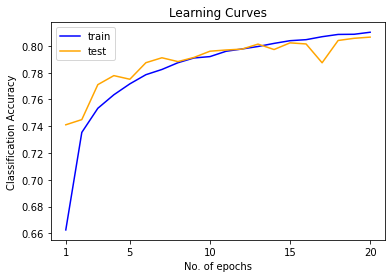

In [28]:
## plot learning curves

plt.title('Learning Curves')
plt.xlabel('No. of epochs')
plt.ylabel('Classification Accuracy')
plt.plot(list(range(1,21)),history.history['accuracy'],color='blue',label='train')
plt.plot(list(range(1,21)),history.history['val_accuracy'],color='orange',label='test')
plt.legend()
plt.xticks([1,5,10,15,20])
plt.show()


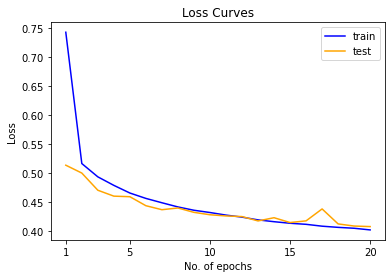

In [29]:
## plot loss curves

plt.title('Loss Curves')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.plot(list(range(1,21)),history.history['loss'],color='blue',label='train')
plt.plot(list(range(1,21)),history.history['val_loss'],color='orange',label='test')
plt.legend()
plt.xticks([1,5,10,15,20])
plt.show()

In [41]:
y_pred = final_model.predict([test_q1, test_q2, features_test])
y_pred

2799/2799 [==============================] - 24s 9ms/step


array([[0.70698303],
       [0.5486956 ],
       [0.7577986 ],
       ...,
       [0.76180845],
       [0.7330413 ],
       [0.6713299 ]], dtype=float32)

Accuracy:  0.8065636375817943


Confusion matrix: 


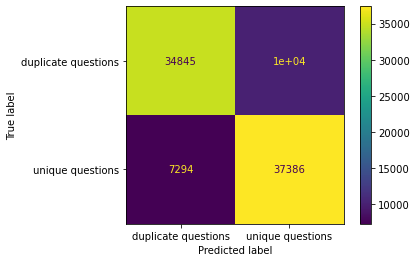

Precision:  0.7884846567541917
Recall:  0.8367502238137869
F-score:  0.8119007546555187


In [47]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, precision_recall_fscore_support, confusion_matrix

th = 0.5
y_pred_binary = np.vectorize(lambda x: 1 if x>=th else 0)(y_pred)

# Accuracy of prediction
print("Accuracy: ", accuracy_score(y_test,y_pred_binary))
print('\n')

# Confusion matrix
print("Confusion matrix: ")
cm = confusion_matrix(y_test,y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['duplicate questions', 'unique questions'])
disp.plot()
plt.show()

# Precision, recall and F-score
scores = precision_recall_fscore_support(y_test, y_pred_binary, average='binary')
print("Precision: ", scores[0])
print("Recall: ", scores[1])
print("F-score: ", scores[2])

In [22]:
keras.backend.clear_session()